# Chapter 3 - NLP Anomaly Detection

Cleanlab, https://cleanlab.ai/, is an open-source library that helps quickly identify problems and outliers in messy and dirty real-world data, enabling more reliable machine learning and analytics by improving data quality for reliable machine learning applications.

For reference, this notebook is tested with TensorFlow version 2.7.4 and Python 3.7.10 using Amazon SageMaker Studio ml.m5.24xlarge general-purpose instance with 96 vCPU and 384 GiB. Link for instance pricing reference. Alternatively, you can try this on your preferred IDE.

## Install and Load the Libraries

In [2]:
!pip install cleanlab sklearn pandas numpy tensorflow==2.7.4 scikeras transformers shap matplotlib

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
from platform import python_version

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Controls amount of tensorflow output

SEED = 42  

np.random.seed(SEED)
random.seed(SEED)

print(f'Tensorflow version: {tf.__version__}')
print(f'Python version: {python_version()}')

Tensorflow version: 2.7.4
Python version: 3.7.10


## Prepare the Data

Load the amazon_reviews.csv raw dataset. There are 5 classes for star_rating. 

In [4]:
df = pd.read_csv("amazon_reviews.csv")
df['star_rating'].unique()

array([5, 2, 3, 1, 4])

Normalize star_rating and create a new target column, **categorical_star_rating**.

In [5]:
# Use LabelEncoder to normalize and encode target labels with value between 0 and n_classes-1.

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df['star_rating'])
df['categorical_star_rating'] = le.transform(df['star_rating'])

df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,categorical_star_rating
0,US,2975964,R1NBG94582SJE2,B00I01JQJM,860486164,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,Camera,5,0,0,N,Y,Five Stars,ok,2015-08-31,4
1,US,23526356,R273DCA6Y0H9V7,B00TCO0ZAA,292641483,Professional 58mm Center Pinch Lens Cap for CA...,Camera,5,0,0,N,Y,Love it!!!,"Perfect, even sturdier than the original!",2015-08-31,4
2,US,52764145,RQVOXO7WUOFK6,B00B7733E0,75825744,Spy Tec Z12 Motion Activated Intelligent Secur...,Camera,2,1,1,N,Y,Another Motion Detect Fail,"If the words, &#34;Cheap Chinese Junk&#34; com...",2015-08-31,1
3,US,47348933,R1KWKSF21PO6HO,B006ZN4U34,789352955,"Celestron UpClose G2 10x25 Monocular, Black (7...",Camera,5,0,0,N,Y,Exactly what I wanted and expected.,Exactly what I wanted and expected. Perfect fo...,2015-08-31,4
4,US,33680700,R38H3UO1J190GI,B00HUEBGMU,19067902,Vidpro XM-L Wired Lavalier microphone - 20' Au...,Camera,5,1,1,N,Y,Good mic at a Good Price...Not Canon Though.,I will look past the fact that they tricked me...,2015-08-31,4


In [6]:
# Create a new dataset

raw_full_ds = df[['review_body','categorical_star_rating']]
raw_full_ds.head(5)

,review_body,categorical_star_rating
0,ok,4
1,"Perfect, even sturdier than the original!",4
2,"If the words, &#34;Cheap Chinese Junk&#34; com...",1
3,Exactly what I wanted and expected. Perfect fo...,4
4,I will look past the fact that they tricked me...,4


In [7]:
# Detect missing values

raw_full_ds.isna()

,review_body,categorical_star_rating
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
539302,False,False
539303,False,False
539304,False,False
539305,False,False


In [8]:
# Removes rows with NULL values

raw_full_ds = raw_full_ds.dropna()
raw_full_ds.isna()

,review_body,categorical_star_rating
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
539302,False,False
539303,False,False
539304,False,False
539305,False,False


In [9]:
# Assign new target column

raw_full_texts = raw_full_ds['review_body']
full_labels = raw_full_ds['categorical_star_rating']

In [10]:
# Set the number of categorical classes

num_classes = len(set(full_labels))  
print(f'Number of classes: {num_classes}')
print(f'Categorical classes: {set(full_labels)}')

Number of classes: 5
Categorical classes: {0, 1, 2, 3, 4}


In [11]:
print(f'Dataset shape: {raw_full_ds.shape}')
print(f'Dataset features: {raw_full_ds.columns}')

Dataset shape: (539241, 2)
Dataset features: Index(['review_body', 'categorical_star_rating'], dtype='object')


In [12]:
# Convert DataFrame into NumPy array

raw_full_texts_arr = raw_full_texts.to_numpy(dtype=str)
raw_full_texts_arr

array(['ok', 'Perfect, even sturdier than the original!',
       "If the words, &#34;Cheap Chinese Junk&#34; come to your mind when you see this, then congratulate yourself.  You're pretty close.  One of the most important features of a 'security camera&#34; is the ability to detect motion and record, especially when running on battery and limited storage space.  I tested the motion detect on this camera in a few different environments so far (i.e. low light, indoors, outdoors, etc..) and all I got was a SD card full of video triggers.  All the testing was done with the low motion sensitivity setting.  I can't even imagine what the high one would be.<br />As others said, the low light operation is poor.  I did one of my tests outdoors as the sun was setting.  It was good until a point - then the camera started having seizures..it got fuzzy, went to black and white...back to color...then ultimately stabilized with lines across the screen.<br />Another oddity I noticed was that the firmw

In [13]:
i = 241130
print(f"Example Label: {full_labels[i]}")
print(f"Example Text: {raw_full_texts[i]}")

Example Label: 3
Example Text: A simple to use flash with good lighting results.  Great for a beginner like myself.


In [14]:
# Clean the data

def preprocess_text(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

In [15]:
# Map text features to integer sequences

from tensorflow.keras import layers

tf.keras.utils.set_random_seed(SEED)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=preprocess_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [16]:
vectorize_layer.adapt(raw_full_texts_arr)
full_texts = vectorize_layer(raw_full_texts_arr)
full_texts = full_texts.numpy()

## Train a Simple Model

We are now ready to build a simple neural network for text classification using TensorFlow and Keras.

In [17]:
# Build a simple neural network for multiclass text classification

from tensorflow.keras import losses, metrics
from tensorflow.keras.optimizers import Adam


def get_net():
    net = tf.keras.Sequential(
        [tf.keras.Input(shape=(None,), dtype="int64"),
         layers.Embedding(max_features + 1, 16),
         layers.Dropout(0.2),
         layers.GlobalAveragePooling1D(),
         layers.Dropout(0.2),
         layers.Dense(num_classes),
         layers.Softmax()]
    )

    net.compile(
        optimizer="adam",
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=metrics.CategoricalAccuracy(),
    )
    return net

Adapt the network to scikit-learn compatibility using SciKeras.

In [18]:
from scikeras.wrappers import KerasClassifier

# Try increase the number of training epochs for better results
model = KerasClassifier(get_net(), epochs=10)

In [19]:
# Use K-fold cross-validation to avoid overfitting during training.

from sklearn.model_selection import cross_val_predict

# Try adjusting num_crossval_folds for better results
num_crossval_folds = 5 
pred_probs = cross_val_predict(
    model, full_texts, full_labels, cv=num_crossval_folds, method="predict_proba", 
)

INFO:tensorflow:Assets written to: ram:///tmp/tmpoa7ctpsu/assets
Epoch 1/10
13481/13481 [==============================] - 35s 3ms/step - loss: 0.9554 - categorical_accuracy: 0.0563
Epoch 2/10
13481/13481 [==============================] - 35s 3ms/step - loss: 0.8026 - categorical_accuracy: 0.1039
Epoch 3/10
13481/13481 [==============================] - 35s 3ms/step - loss: 0.7786 - categorical_accuracy: 0.1054
Epoch 4/10
13481/13481 [==============================] - 35s 3ms/step - loss: 0.7676 - categorical_accuracy: 0.1056
Epoch 5/10
13481/13481 [==============================] - 35s 3ms/step - loss: 0.7607 - categorical_accuracy: 0.1060
Epoch 6/10
13481/13481 [==============================] - 35s 3ms/step - loss: 0.7566 - categorical_accuracy: 0.1056
Epoch 7/10
13481/13481 [==============================] - 35s 3ms/step - loss: 0.7527 - categorical_accuracy: 0.1055
Epoch 8/10
13481/13481 [==============================] - 35s 3ms/step - loss: 0.7494 - categorical_accuracy: 0.1053

In [20]:
from sklearn.metrics import log_loss

loss = log_loss(full_labels, pred_probs)  # score to evaluate probabilistic predictions, lower values are better
print(f"Cross-validated estimate of log loss: {loss:.3f}")

Cross-validated estimate of log loss: 0.762


## Find Label Anomaly

Cleanlab identifies label errors using self-confidence score ranking to measure label quality based on predicted probabilities.

In [21]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    labels=full_labels, pred_probs=pred_probs, return_indices_ranked_by="self_confidence"
)


In [22]:
# Top 10 potential label anomalies

print(
    f"Cleanlab identified {len(ranked_label_issues)} potential label errors.\n Indices of the top 10 most likely errors: \n {ranked_label_issues[:10]}"
)

Cleanlab identified 97144 potential label errors.
 Indices of the top 10 most likely errors: 
 [380788 421617 137772 417544  26876 296289  48831  78686 274579 133527]


In [23]:
pd.set_option("display.max_colwidth", None)

# view top-ranked label issues found by cleanlab
def potential_label_anomaly(index):
    return pd.DataFrame({"Reviews": raw_full_texts[index], "Categorical labels": full_labels[index]}, [index])

In [30]:
potential_label_anomaly(133527)

,Reviews,Categorical labels
133527,"I was really tempted to give this case a one star just to get people to read my review. Let's face it, most people are really only looking for the bad in something before they buy it. That said, don't mess around, get this case if you have a Phantom 3. The cut-outs fit everything perfectly. The large slot on the left, that's configurable, fits my Samsung Galaxy Tab S 10.5&#34; tablet that I use for the pilot app, and the props. You could fit more in there but that's all I needed. This case has a great price and is built like a nuclear waste transport cask. I'm pretty sure you could put your copter in this case, throw it in front of a high speed train and - unfortunately - you might end up having to recalibrate your gimbal. :-) Seriously, this is a strong case and it's lightweight. One of the things that really surprised me is the company. I know you're not supposed to mention anything about the company or shipping in a review but, they deserve credit here... After I ordered the case, Fuerte Cases had it shipped out in less than two hours from California and I received it in four business days. I was floored by their professionalism. Thank you Fuerte Cases. ***** A Very Important Special Note: If you are unfamiliar with the Phantom 3 battery, it is programmed to discharge automatically to below 75% if it is charged to 100% and left unused over a short period of time. DJI says it will take the battery 3 days to discharge from 100% to 75%. The reason I am mentioning this is; the battery will get hot during that time so you don't want to have it in any case. The way to avoid this is; if you charge your battery, and this goes for the controller as well, and end up not being able to use your copter for more than a few days - discharge the batteries before you store them in the case and you will be fine. They should be discharged to between 35% and 75%. Fly safe everyone... Oh', did I mention - get this case.",4


In [25]:
potential_label_anomaly(137772)

,Reviews,Categorical labels
137772,meets the expectations but it can be improved a lot,2


## Train a Better Model

Manually inspecting and fixing potential label errors can be time-consuming. We can train a better model using Cleanlab to filter noisy data.

In [31]:
# Split the training and test dataset

from sklearn.model_selection import train_test_split

raw_train_texts, raw_test_texts, train_labels, test_labels = train_test_split(raw_full_texts, full_labels, test_size=0.2, random_state=42)

raw_train_texts.to_numpy(dtype=str)
raw_test_texts.to_numpy(dtype=str)

array(['Very poor quality.', 'Good replacement',
       "Just a hair too big. It's exactly 49mm, which means it fits very snuggly into the filter threads. It worked, though, so that counts. If you sand about .5mm off around the edge, it will be perfect. I've been looking for something like this that was affordable for a while now. Definitely worth it for the extra 5 minutes it takes to make it perfect.",
       ..., "For the price, don't bother.",
       'Absolutely what expected out of the product and received it very fast.',
       'This battery is packaged to protect it in shipment. The battery is well built and provides service and endurance above that which I expected for this reasonable price.'],
      dtype='<U45403')

In [32]:
print(f'raw_train_texts shape: {raw_train_texts.shape}')
print(f'train_labels shape: {train_labels.shape}')
print(f'raw_test_texts shape: {raw_test_texts.shape}')
print(f'test_labels shape: {test_labels.shape}')

raw_train_texts shape: (431392,)
train_labels shape: (431392,)
raw_test_texts shape: (107849,)
test_labels shape: (107849,)


In [33]:
# Vectorize the raw text and convert to NumPy arrays

vectorize_layer.reset_state()
vectorize_layer.adapt(raw_train_texts)

train_texts = vectorize_layer(raw_train_texts)
test_texts = vectorize_layer(raw_test_texts)

train_texts = train_texts.numpy()
test_texts = test_texts.numpy()

In [34]:
# Start the training and evaluation

from sklearn.metrics import accuracy_score

model = KerasClassifier(get_net(), epochs=10)
model.fit(train_texts, train_labels)
preds = model.predict(test_texts)
acc_og = accuracy_score(test_labels, preds)

print(f'Test accuracy of original neural net: {acc_og}')

Epoch 1/10
13481/13481 [==============================] - 34s 3ms/step - loss: 0.9605 - categorical_accuracy: 0.0563
Epoch 2/10
13481/13481 [==============================] - 34s 3ms/step - loss: 0.8059 - categorical_accuracy: 0.1051
Epoch 3/10
13481/13481 [==============================] - 34s 3ms/step - loss: 0.7795 - categorical_accuracy: 0.1059
Epoch 4/10
13481/13481 [==============================] - 34s 2ms/step - loss: 0.7691 - categorical_accuracy: 0.1061
Epoch 5/10
13481/13481 [==============================] - 34s 3ms/step - loss: 0.7611 - categorical_accuracy: 0.1059
Epoch 6/10
13481/13481 [==============================] - 33s 2ms/step - loss: 0.7566 - categorical_accuracy: 0.1056
Epoch 7/10
13481/13481 [==============================] - 35s 3ms/step - loss: 0.7529 - categorical_accuracy: 0.1055
Epoch 8/10
13481/13481 [==============================] - 34s 2ms/step - loss: 0.7495 - categorical_accuracy: 0.1055
Epoch 9/10
13481/13481 [==============================] - 34s 3m

The CleanLearning wrapper class trains the original with cross-validation to produce predicted probabilities for potential label errors. The noisy data with label errors are removed from the dataset before retraining the original model with the remaining clean data.

In [35]:
from cleanlab.classification import CleanLearning

model = KerasClassifier(get_net(), epochs=10)  
cl = CleanLearning(clf=model, seed=SEED)  

In [36]:
_ = cl.fit(train_texts, train_labels)

INFO:tensorflow:Assets written to: ram:///tmp/tmpjtourmpk/assets
Epoch 1/10
10785/10785 [==============================] - 31s 3ms/step - loss: 0.9831 - categorical_accuracy: 0.0433
Epoch 2/10
10785/10785 [==============================] - 31s 3ms/step - loss: 0.8177 - categorical_accuracy: 0.1022
Epoch 3/10
10785/10785 [==============================] - 31s 3ms/step - loss: 0.7843 - categorical_accuracy: 0.1053
Epoch 4/10
10785/10785 [==============================] - 32s 3ms/step - loss: 0.7710 - categorical_accuracy: 0.1060
Epoch 5/10
10785/10785 [==============================] - 30s 3ms/step - loss: 0.7629 - categorical_accuracy: 0.1058
Epoch 6/10
10785/10785 [==============================] - 31s 3ms/step - loss: 0.7568 - categorical_accuracy: 0.1062
Epoch 7/10
10785/10785 [==============================] - 31s 3ms/step - loss: 0.7528 - categorical_accuracy: 0.1062
Epoch 8/10
10785/10785 [==============================] - 31s 3ms/step - loss: 0.7487 - categorical_accuracy: 0.1058

The Cleanlab-trained model behaves the same as the original model to make predictions. Test accuracy improved slightly after data cleaning for this example.

In [37]:
pred_labels = cl.predict(test_texts)
acc_cl = accuracy_score(test_labels, pred_labels)
print(f'Test accuracy of Cleanlab\'s neural net: {acc_cl}')

3371/3371 [==============================] - 2s 674us/step
Test accuracy of Cleanlab's neural net: 0.7232055930050348


## Evaluate NLP Explainability

NLP Explainability typically involves removing or masking random words from dataset. We will use [SHAP](https://github.com/slundberg/shap) to evaluate and visualize the feature attributions of individual classes for multiclass classification. We use BERT fine-tuned model to classify positive versus negative sentiment for the product reviews.

In [38]:
# load the dataset

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import transformers
import shap

dataset = pd.read_csv('amazon_reviews.csv')
data = pd.DataFrame({'text':dataset['review_body'],'sentiment':dataset['star_rating']})

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
# Load the model

import transformers

model = transformers.pipeline(
    'sentiment-analysis',
    model='distilbert-base-uncased-finetuned-sst-2-english',
    top_k=None
)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_25']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# Pass the transformers pipeline object directly to shap.Explainer

explainer = shap.Explainer(model)

In [42]:
# Pass a list of text to explain the classifications.

shap_values = explainer(data['text'][137772:137775])

 99%|█████████▉| 494/498 [01:05<00:00,  6.88it/s]
500it [01:06,  6.89it/s]                         
504it [01:07,  6.90it/s]
 75%|███████▍  | 82/110 [00:00<00:00, 188.16it/s]
Partition explainer: 4it [01:30, 30.25s/it]                       


## Visualize Feature Attributions

Hover over an output class to see the explanation for a predicted output class. The base value represents the model outputs when the entire input text is removed or masked. The $f_{outputclass}(inputs)$ is the output for the full original input. SHAP values shows the impact of unmasking each word deviates from the base value.

In [43]:
shap.plots.text(shap_values)

In [44]:
# Slicing a single output class. For example, POSITIVE only

shap.plots.text(shap_values[:, :, "POSITIVE"])

In [45]:
# Slicing a single output class. For example, NEGATIVE only

shap.plots.text(shap_values[:, :, "NEGATIVE"])

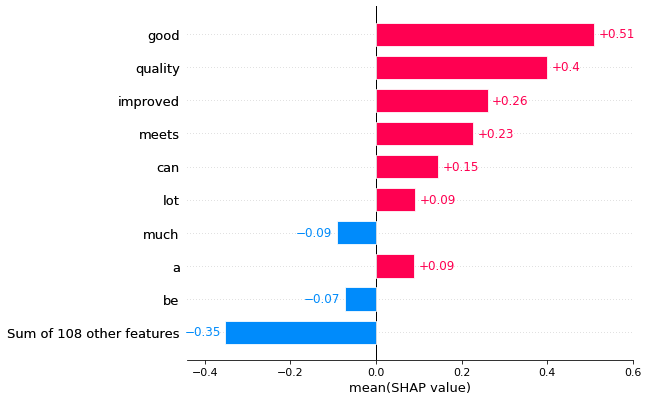

In [46]:
# Top words impacting a specific class

shap.plots.bar(shap_values[:,:,"POSITIVE"].mean(0))

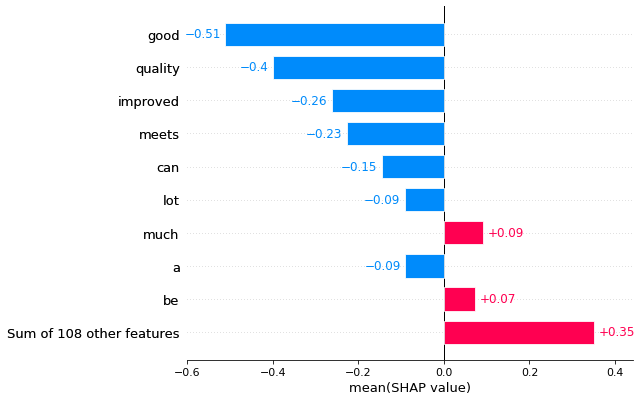

In [47]:
# Top words impacting a specific class

shap.plots.bar(shap_values[:,:,"NEGATIVE"].mean(0))

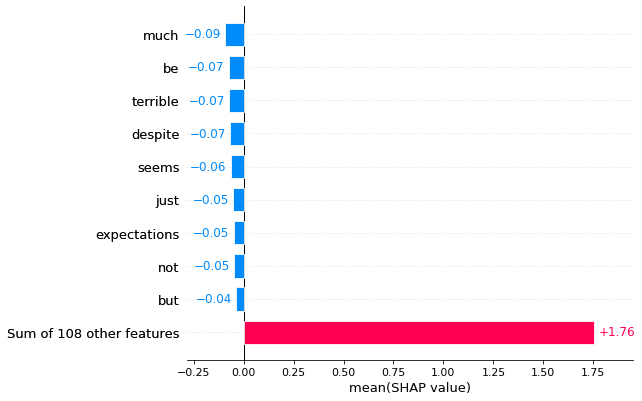

In [48]:
# Sort the bar chart in descending order

shap.plots.bar(shap_values[:,:,"POSITIVE"].mean(0), order=shap.Explanation.argsort)

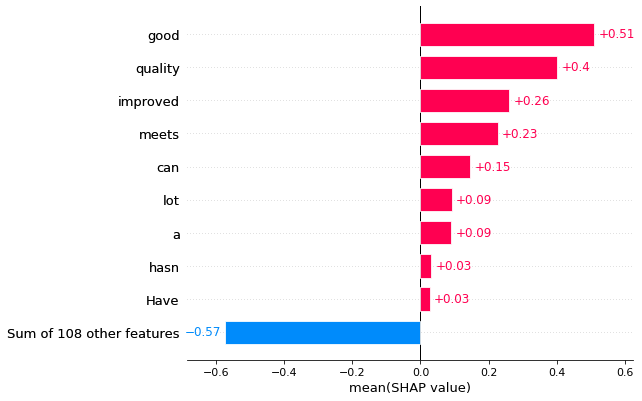

In [49]:
# Sort the bar chart in ascending order

shap.plots.bar(shap_values[:,:,"POSITIVE"].mean(0), order=shap.Explanation.argsort.flip)

This concludes the NLP anomaly explainability for multiclass text classification example.